In [ ]:
# Beispiel aus dem IX Artikel

import sys
import pandas as pd
import sklearn
import spacy
import gensim
 
!{sys.executable} -m spacy download de
nlp = spacy.load('de')
doc = nlp("Krafti nein, ich mache hier jetzt selber.")
spacy.displacy.render(doc, style='dep', jupyter=True)

<h1> einlesen der Daten <h1>

In [2]:
# import von Pandas, Betriebssystemfunktionen als  Bibliotheken laden
import pandas as pd
import json
import os

<h2>Es folgen die Angaben der Speicherorte.<h2>

In [3]:
file_path = './data/'

# try to clean the raw date
# open the data json file and load it into the RAM
with open(file_path + 'data.json') as infile:
    # read the json structure
    d = json.load(infile)
    
    # d is a list of dict objects
    for book in d:
        # every book is a dict
        for key in book.keys():
            # replace the \n - new line character with a whitespace
            book[key] = book[key].replace('\n', ' ')
            # replace some worde with whitespace
            book[key] = book[key].replace('[Fußnote]', ' ')
            
        book['year_dt'] = pd.to_datetime(book['year'], infer_datetime_format=True)
    
            

<h2> Daten in ein speichereffizientes Format bringen <h2>

In [4]:
# put all of the books into an pandas Dataframe
data = pd.DataFrame(d).set_index('number')

<h2>Mit dem folgenden Befehlen verschaffen wir uns einen Überblick über die eingeladenen Daten.<h2>

In [5]:
data  


,name,style,text,year,year_dt
number,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 0001 to 0080
Data columns (total 5 columns):
name       80 non-null object
style      80 non-null object
text       80 non-null object
year       80 non-null object
year_dt    48 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 3.8+ KB


In [7]:
data.describe()

,name,style,text,year,year_dt
count,80,80,80,80,48
unique,80,7,80,24,23
top,Don Carlos,L,"Zu Aachen in seiner Kaiserpracht, I...",,1797-01-01 00:00:00
freq,1,52,1,32,10
first,NaN,NaN,NaN,NaN,1776-01-01 00:00:00
last,NaN,NaN,NaN,NaN,1805-01-01 00:00:00


<h1>NLP<h1>

<h2>Vorbereitung<h2>

Nun benötigen wir die spaCY-Bibliothek und da Modell für die deutsche Sprache.

Mehr zu spaCY: https://spacy.io

In [8]:
import spacy
from spacy.lang.de import German

nlp = spacy.load('de')

Das durch spaCY erzeugte NLP-Objekt ist sehr groß und benötigt viel Speicher. Um das etwas zu entschärfen,
werden nur die benötigen Daten, also Anzahl der Token, Adjektive, Substantive und Verben gespeichert. 
Dabei hilft defaultdict, weil hier alle Werte auf 0 gesetzt sind, das spart viele Fallunterscheidungen.

Die Worte selbst werden auch in ihrer lemmatisierten Form (also grammatikalisch auf die Grundform reduziert)
benötigt, um später Analysen damit durchführen zu können.

In [98]:
%time
from collections import defaultdict

def calculate_the_word_types(data):
    nouns = defaultdict(lambda: 0)
    verbs = defaultdict(lambda: 0)
    adjectives = defaultdict(lambda: 0)

    for i, row in data.iterrows():
        doc = nlp(row["name"] + " " + row["text"])
    data.set_value(i, "nr_token", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ != 'PUNCT', doc)))))
    
    for a in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'ADJ', doc)):
        adjectives[a] += 1
    data.set_value(i, "nr_adj", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'ADJ', doc)))))  
    
    for n in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'NOUN', doc)):
        nouns[n] +=1
    data.set_value(i, "nr_noun", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'NOUN', doc)))))

    for v in map(lambda x: x.lemma_, filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)):
        verbs[v] += 1
    data.set_value(i, "nr_verb", len(list(map(lambda x: x.text, 
                                         filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)))))  
    
    return data


###############################################
#
#
#          ACHTUNG DAS AUSFÜHREN DAUERT
#
#
#
#    KNAPP 5 MINUTEN - BITTE das PICKLE laden
#
#               !!!!!!!!!!!!!!!
#
##############################################


#data = calculate_the_word_types(data)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [144]:
# save the data into a pickle to save some time


import pickle

# save it
#with open('./data/output_df_wth_nr_token_verb_noun_adj.pickle', 'wb') as handle:
#    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load it
with open('./data/output_df_wth_nr_token_verb_noun_adj.pickle', 'rb') as handle:
    data = pickle.load(handle) 

<h1>Auswertung</h1>

<h2> Wieviel Werke sind pro Jahr in der Datenbank</h2>

In [133]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
#%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
from pandas.plotting import register_matplotlib_converters as rmc
rmc()

In [134]:
# create a schiller style color palette
schiller_type_colors = ['#78C850',  # Grass
                        #'#F08030',  # Fire
                        #'#6890F0',  # Water
                        #'#A8B820',  # Bug
                        #'#A8A878',  # Normal
                        #'#A040A0',  # Poison
                        '#F8D030',  # Electric
                        #'#E0C068',  # Ground
                        #'#EE99AC',  # Fairy
                        '#C03028',  # Fighting
                        #'#F85888',  # Psychic
                        #'#B8A038',  # Rock
                        #'#705898',  # Ghost
                        #'#98D8D8',  # Ice
                        '#7038F8',  # Dragon
                       ]

"\nx_pos = [x for x in range(1776, 1806)]\nprint(x_pos)\n# swarm plot with schiller color palette\nsns.swarmplot(x='year', y='nr_token', data=df,\n             palette=schiller_type_colors)\nplt.xticks(rotation=90)\n# Thus we have to give more margin:\nplt.subplots_adjust(bottom=0.4)\n\nplt.axvline(8, color='r', linestyle='--', lw=2)\nplt.plot()\n"

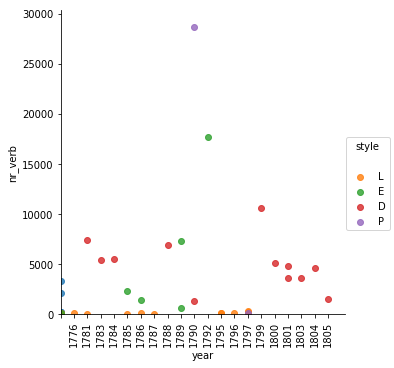

In [136]:
df = data.sort_values(["year"], ascending=True)[["name", "nr_verb", "year", "style"]]

# Plot using Seaborn
sns.lmplot(x='year', y='nr_verb', data=df,
          fit_reg=False,
          hue='style')

# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, None)
plt.xticks(rotation=90)





"""
x_pos = [x for x in range(1776, 1806)]
print(x_pos)
# swarm plot with schiller color palette
sns.swarmplot(x='year', y='nr_token', data=df,
             palette=schiller_type_colors)
plt.xticks(rotation=90)
# Thus we have to give more margin:
plt.subplots_adjust(bottom=0.4)

plt.axvline(8, color='r', linestyle='--', lw=2)
plt.plot()
"""

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

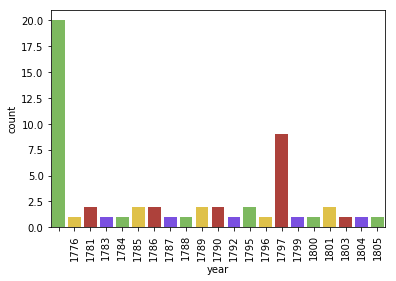

In [138]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='year', data=df, palette= schiller_type_colors)

# Rotate x-labels
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

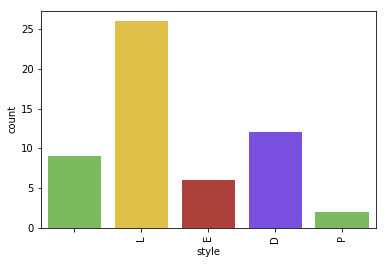

In [140]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='style', data=df, palette= schiller_type_colors)

# Rotate x-labels
plt.xticks(rotation=90)

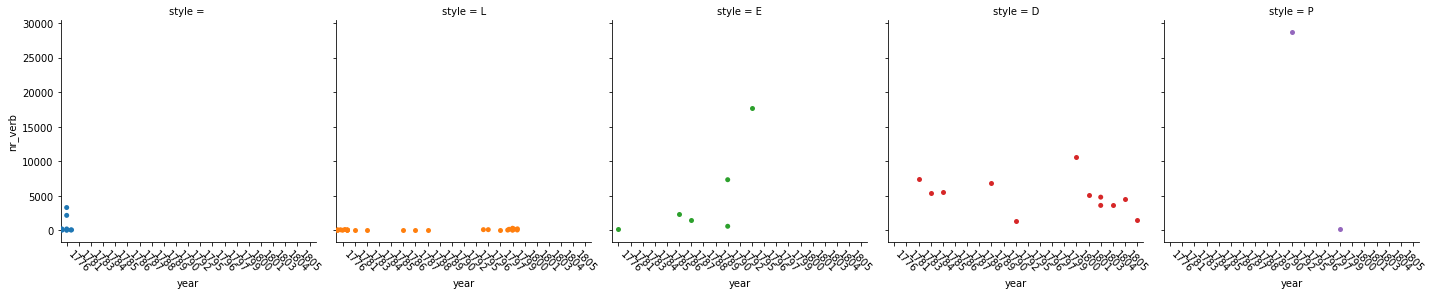

In [142]:
# Factor Plot
g = sns.factorplot(x='year',
                  y='nr_verb',
                  data=df,
                  hue='style', # Color by stage
                  col='style', # Separate by stage
                  kind='swarm') # Swarmplot

# rotate x-axis labels
g.set_xticklabels(rotation=-45)

# Doesn't work because only rotates last plot
# plt.xticks(rotation=-45)

<h2>Verteilung der Textlänge über die Zeit</h2>

Aus dem vorhandenen DataFrame wird nun ein neuer erzeugt, der lediglich die beiden Felder 
year und nr_token besitzt.


In [82]:
text_length = data[["year", "nr_token"]]

Ab jetzt wird es visuell! Die %-Anweisung wird benötigt, damit Jupyter die Plots direkt im Notebook anzeigen kann.
Hier wird matplotlib zur Visualisierung benutzt, die numpy-Bibliothek für die numerische Datenverarbeitung 
wird später noch häufiger benötigt.

Mehr zur Inline-Darstellung in Jupyter: https://ipython.readthedocs.io/en/stable/interactive/plotting.html

Mehr zu matplotlib: https://matplotlib.org

Mehr zu numpy: http://www.numpy.org

Mehr zu set_index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html

Mehr zu agg: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

Mehr zu rename: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html

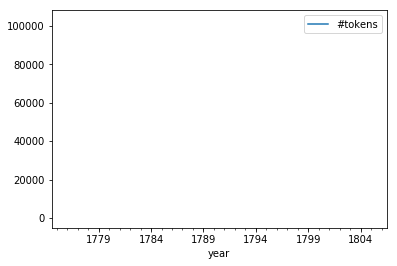

In [87]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np



data[["year", "nr_token"]].set_index("year").resample('M').\
       agg({'nr_token': 'mean'}).rename(columns={'nr_token': '#tokens'}).plot()

In [145]:
data

,name,style,text,year,year_dt,nr_token,nr_adj,nr_noun,nr_verb
number,,,,,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01,8486.0,600.0,1681.0,1482.0
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01,7127.0,584.0,1328.0,1286.0
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01,27129.0,2348.0,5122.0,3624.0
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01,32189.0,2308.0,6195.0,4801.0
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01,42202.0,3047.0,7807.0,7432.0
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01,30978.0,2404.0,6242.0,5382.0
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01,45823.0,2795.0,7636.0,6911.0
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01,31778.0,2347.0,6126.0,5484.0
0010,Maria Stuart,D,Maria Stuart Trauerspiel in fünf Aufzügen Eli...,1800,1800-01-01,34801.0,2258.0,6491.0,5173.0


<h2>Liste der längsten Artikel</h2>

Mehr zur Sortierung: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

Mehr zur Spaltenauswahl: https://pandas.pydata.org/pandas-docs/stable/indexing.html

In [88]:
data.sort_values(["nr_token"], ascending=False)[["name", "nr_token", "year"]].head(10)

,name,nr_token,year
number,,,
0045,die Geschichte des 30jaehrigen Krieges,198543.0,1790-01-01
0055,Geschichten aus dem alten Pitaval,98015.0,1792-01-01
0012,Wallenstein,71183.0,1799-01-01
0008,Don Carlos,45823.0,1788-01-01
0006,Die Räuber,42202.0,1781-01-01
0021,der Geisterseher,39067.0,1789-01-01
0010,Maria Stuart,34801.0,1800-01-01
0005,Die Jungfrau von Orleans,32189.0,1801-01-01
0013,Wilhelm Tell,32164.0,1804-01-01
